In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import torch

from find_transform import aligned_coords2line
from refine_transform import match_two_aligned_fragments

from tqdm import tqdm
from utils import *
from refine_transform import *
from find_transform import *
from shape_align import new_pairwise_alignment
from skimage.color import rgb2lab, lab2rgb

In [2]:
data_dir = '../../dataset'
palette = np.array([[4.83058360e+01, -4.28336049e+00, -1.04226657e+00],
                    [7.28763389e+01,  1.10190913e+01,  2.91083397e+01],
                    [1.93975643e+01,  8.21757008e+00, -6.52862709e+00],
                    [6.12470461e+01,  6.38868771e+00,  1.05191202e+01],
                    [8.70237508e+01,  2.60029629e+00,  6.34060233e+00],
                    [3.84328672e+01,  2.22768163e+01,  1.17465682e+00],
                    [3.29131583e+01,  3.06846260e-02, -6.19825618e+00]])

In [3]:
frag1 = pad_fragment_to_size(build_fragment_from_directory(data_dir + '/9'), 200)
frag2 = pad_fragment_to_size(build_fragment_from_directory(data_dir + '/11'), 200)

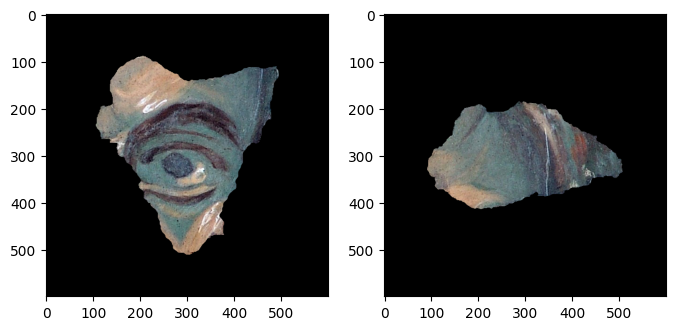

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,6))
axes[0].imshow(frag1.fragment)
axes[1].imshow(frag2.fragment)

In [33]:
# frag_numbers = [3, 5, 6, 9, 11, 14]
frag_numbers = [5, 9]
frags = [pad_fragment_to_size(build_fragment_from_directory(data_dir + '/' + str(i)), 200) for i in frag_numbers]

In [34]:
# frags = [
#     pad_fragment_to_size(build_fragment_from_directory(data_dir + '/3'), 200),
#     pad_fragment_to_size(build_fragment_from_directory(data_dir + '/5'), 200),
#     pad_fragment_to_size(build_fragment_from_directory(data_dir + '/6'), 200),
#     pad_fragment_to_size(build_fragment_from_directory(data_dir + '/9'), 200),
#     pad_fragment_to_size(build_fragment_from_directory(data_dir + '/11'), 200),
#     pad_fragment_to_size(build_fragment_from_directory(data_dir + '/14'), 200),
# #     pad_fragment_to_size(build_fragment_from_directory(data_dir + '/15'), 200)
# ]


In [35]:
descriptors, alignments = new_pairwise_alignment(palette,frags, blocks_num=5)

Computing shape descriptors...
Computing pairwise alignments...
Aligning fragments 0 and 1:


100%|████████████████████████████████████████████████████████████████████████████████| 764/764 [00:04<00:00, 172.79it/s]


25
9


In [60]:
l, r = 0, 1
align_index = 8

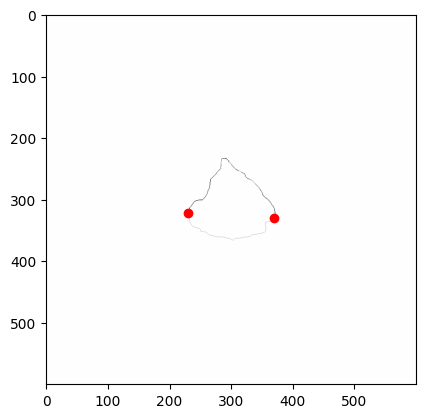

In [61]:
# common_edge = np.ones((frags[l].fragment.shape[0] * 2, frags[l].fragment.shape[1] * 2, 3))
common_edge = np.ones(frags[l].fragment.shape)
color_edge, edge_coords, curvs = descriptors[l].color_edge, descriptors[l].edge_coords, descriptors[l].curvatures
indices = alignments[(l, r)][align_index].indices
i_indices = [i for (i, j) in indices]
for i, point in enumerate(edge_coords):
#     print(point)
    common_edge[point[0], point[1]] = 0.8
common_edge = rgb2lab(common_edge)
    
for (i, j) in indices:
    color = color_edge[i - 1]
    y, x = edge_coords[i - 1]
    common_edge[y, x] = color

plt.imshow(lab2rgb(common_edge))
common_edge = lab2rgb(common_edge)
y1, x1 = edge_coords[indices[0][0] - 1]
y2, x2 = edge_coords[indices[-1][0] - 1]
plt.scatter([x1, x2], [y1, y2], color='r')
plt.imshow(common_edge)

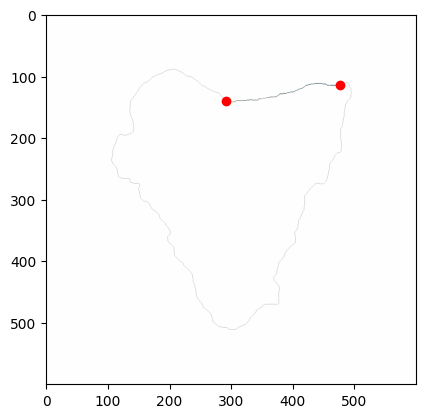

In [62]:
common_edge = np.ones(frags[r].fragment.shape)
color_edge, edge_coords, curvs = descriptors[r].color_edge[::-1], descriptors[r].edge_coords[::-1], descriptors[r].curvatures[::-1]
indices = alignments[(l, r)][align_index].indices
i_indices = [j for (i, j) in indices]
for i, point in enumerate(edge_coords):
    common_edge[point[0], point[1]] = 0.8
common_edge = rgb2lab(common_edge)
    
for (i, j) in indices:
    color = color_edge[j - 1]
    y, x = edge_coords[j - 1]
    common_edge[y, x] = color

plt.imshow(lab2rgb(common_edge))
common_edge = lab2rgb(common_edge)
y1, x1 = edge_coords[indices[0][1] - 1]
y2, x2 = edge_coords[indices[-1][1] - 1]
plt.scatter([x1, x2], [y1, y2], color='r')
plt.imshow(common_edge)

In [11]:
mobilenet = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
feature_extractor = torch.nn.Sequential(
    mobilenet.features[0],
)
conv = mobilenet.features[0][0]
conv.stride = (1, 1)
feature_extractor = conv
feature_extractor.requires_grad_(False)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [12]:

def check_possibility_of_translation(anchor_frag, transformed_frag):
    intersects = np.logical_and(anchor_frag.mask, transformed_frag.mask).any()
    ext1_intersects2 = np.logical_and(anchor_frag.extended_mask, transformed_frag.mask).any()
    ext2_intersects1 = np.logical_and(transformed_frag.extended_mask, anchor_frag.mask).any()

    intersection = np.logical_and(anchor_frag.extended_mask, transformed_frag.extended_mask).sum()
    too_small_ext_intersection = max(intersection / anchor_frag.extended_mask.sum(), intersection / transformed_frag.extended_mask.sum()) < 0.025

    return not intersects and (ext1_intersects2 or ext2_intersects1) and not too_small_ext_intersection

In [13]:
def compute_new_content_score(frag1, frag2, features1, features2, resized_mask1, resized_mask2, shift, eps=0.001):
    """
    frag1 - fragment
    frag2 - transformed fragment
    features1 - frag1 features from pre-trained model, shape (n_features, height, width)
    features2 - frag2 features from pre-trained model, shape (n_features, height, width)
    shift - translation (shift_x, shift_y) frag1 -> frag2
    """
#     img_cross_corr = compute_content_score(frag1, frag2)
    pad = min(frag1.fragment.shape[0], frag2.fragment.shape[0])
    padded_features1 = np.pad(features1, ((0, 0), (pad, pad), (pad, pad)))
    padded_features2 = np.pad(features2, ((0, 0), (pad, pad), (pad, pad)))
    
    shifted_features1 = padded_features1[:,pad - shift[1]: -pad - shift[1], pad - shift[0]: -pad - shift[0]]

    if len(resized_mask2.shape) == 2:
        resized_mask2 = resized_mask2[:, :, None]
    if len(resized_mask1.shape) == 2:
        resized_mask1 = resized_mask1[:, :, None]

    padded_mask1 = np.pad(resized_mask1, ((pad, pad), (pad, pad), (0, 0)))
    shifted_mask1 = padded_mask1[pad - shift[1]: -pad - shift[1], pad - shift[0]: -pad - shift[0]]
    where = np.logical_and(resized_mask2, shifted_mask1).transpose(2, 0, 1)
    
    features2_masked = features2 * where
    features1_masked = shifted_features1 * where
    features_cov = (features1_masked * features2_masked).sum()
    features_cross_corr = features_cov / np.sqrt((features1_masked ** 2).sum() * (features2_masked ** 2).sum() + eps)
    return features_cross_corr

def match_two_aligned_fragments(frag1, frag2, list_of_initial_params, subcurves1, subcurves2, feature_extractor, beta=0.5, pad_size=200, verbose=1, eps=0.001):
    """
    list_of_initial_params: list of (angle, x, y)
    frag1, frag2: Fragments
    subcurves1, subcurves2: common subcurves from frag1 and frag2, each corresponds to initial_params
    finds optimal translation between frag1 -> frag2
    return: list of optimal translations (after non-max suppression)
    """
    padded_frag1 = pad_fragment_to_size(frag1, pad_size)
    padded_frag2 = pad_fragment_to_size(frag2, pad_size)
    
    tensor2 = torch.tensor(padded_frag2.extended_frag, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
    if tensor2.max() > 1:
        tensor2 = tensor2 / 255
    features2 = feature_extractor(tensor2)
    features2 = features2.squeeze(0).detach().numpy()
    
    global_res = []
    
    for params_index, initial_params in enumerate(list_of_initial_params):
        best_translation = None
        theta, x_initial, y_initial = initial_params
        print(f"theta = {theta}, x_initial = {x_initial}, y_initial = {y_initial}")
        subcurve1 = subcurves1[params_index]
        subcurve2 = subcurves2[params_index]
        
        shifts = [(x, y) for x in range(x_initial - 30, x_initial + 31, 6) for y in range(y_initial - 30, y_initial + 31, 6)]
        for phi in np.arange(theta - 15, theta + 16, 5):
#             if verbose == 1:
#                 print(f"phi = {phi}, params_index = {params_index}")
#             rot_frag2 = rotate_fragment(padded_frag2, phi)
            rot_frag1 = rotate_fragment(padded_frag1, phi)
            tensor1 = torch.tensor(rot_frag1.extended_frag, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
            if tensor1.max() > 1:
                tensor1 = tensor1 / 255
            features1 = feature_extractor(tensor1)
            features1 = features1.squeeze(0).detach().numpy()

            good_shifts = []
            for (x, y) in tqdm(shifts) if verbose == 1 else shifts:
#                 transformed2 = shift_fragment(rot_frag2, x, y) # TODO: fix x and y
                transformed1 = shift_fragment(rot_frag1, x, y)
                if check_possibility_of_translation(padded_frag2, transformed1):
                    geom_score = compute_fast_geom_morph_score(subcurve1, subcurve2, (phi, y, x), max_distance=50)
#                     print("Translation is possible")
#                     print(f"geom_score = {geom_score}")
                    prob = geom_score
                    if prob > 0.5:
                        good_shifts.extend([(x_new, y_new) for x_new in range(x - 2, x + 3, 2) for y_new in range(y - 2, y + 3, 2)])
            for (x, y) in tqdm(good_shifts) if verbose == 1 else good_shifts:
#                 transformed2 = shift_fragment(rot_frag2, x, y) # TODO: fix x and y
                transformed1 = shift_fragment(rot_frag1, x, y)
#                 if check_possibility_of_translation(padded_frag1, transformed2):
                if check_possibility_of_translation(padded_frag2, transformed1):
                    geom_score = compute_fast_geom_morph_score(subcurve1, subcurve2, (phi, y, x), max_distance=50)
                    prob = geom_score
#                     print("Translation is possible")
#                     print(f"geom_score = {geom_score}")
                    if prob > 0.5:
#                         geom_score2 = compute_geom_morph_score(frag1, frag2)
#                         geom_score = (geom_score1 + geom_score2) / 2
#                         content_score = compute_new_content_score(
#                             padded_frag2, transformed1,
#                             features2, features1,
#                             padded_frag2.extended_mask, transformed1.extended_mask,
#                             (x, y)                        
#                         )
                        content_score = compute_cross_correlation(padded_frag2, transformed1)
#                         print(f"content_score = {content_score}")
                        prob = (1 + beta) / (1 / (content_score) + beta * 1 / (geom_score + eps))
#                         if prob > 0.4:
#                             print(f"geom_score = {geom_score}, content_score = {content_score}, prob = {prob}, x = {x}, y = {y}, phi = {phi}")
                        trans = Translation(x, y, phi, prob)
                        if best_translation is None or best_translation.confidence < trans.confidence:
                            best_translation = trans
        if best_translation is None:
            continue
        global_res.append(best_translation)
            
    filtered_res = nms(sorted(global_res, reverse=True, key=lambda val: val.confidence).copy())
    return filtered_res

In [14]:
start_time = time.time()
refined_alignment = {}
for l in range(0, len(frags)):
    for r in range(l + 1, len(frags)):
        print("Refining transform between {} and {}".format(l, r))
        
        list_of_initial_params = []
        subcurves1 = []
        subcurves2 = []
        for alignment in alignments[(l, r)][:4]:
            line1 = aligned_coords2line(alignment.indices, descriptors[l].edge_coords, left=True)
            line2 = aligned_coords2line(alignment.indices, descriptors[r].edge_coords[::-1], left=False)
            line1 -= frags[l].fragment.shape[0] // 2
            line2 -= frags[r].fragment.shape[0] // 2
            best_transform_params = find_best_transform_ransac(line1, line2)
            print(best_transform_params)
            if best_transform_params is None:
                print("No best transform")
                continue
            cos = best_transform_params[0]
            cos = min(cos, 1)
            cos = max(cos, -1)
            theta, shift_x, shift_y = -np.rad2deg(np.arccos(cos)), best_transform_params[3], best_transform_params[2] # TODO: fix angle computation [0, pi] -> [-pi, pi]
            list_of_initial_params.append((theta, int(shift_x), int(shift_y)))
            subcurves1.append(line1)
            subcurves2.append(line2)
    
        res = match_two_aligned_fragments(
            pad_fragment_to_size(frags[l], 200),
            pad_fragment_to_size(frags[r], 200),
            list_of_initial_params,
            subcurves1,
            subcurves2,
            feature_extractor,
            verbose=1
        )
        print(len(res))
        if len(res) > 0:
#             res = [tr for tr in res if tr.confidence > 0.5]
            tr = sorted(res, reverse=True, key=lambda val: val.confidence)
            refined_alignment[(l, r)] = tr
print("--- %s seconds ---" % (time.time() - start_time))

Refining transform between 0 and 1
[  0.92307692  -0.38461538 205.61538462  13.07692308]
[ -0.70629371  -0.71328671 152.12587413  37.62937063]
[ 1.00365965e+00  6.03842635e-02 -5.99634035e+01  1.34603843e+02]
[  -0.78974359   -0.65128205  -89.26153846 -163.75897436]
theta = -22.619864948040405, x_initial = 13, y_initial = 205


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 121.29it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 42.98it/s]


theta = -134.934155606434, x_initial = 37, y_initial = 152


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 127.02it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 124.22it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 57.69it/s]


theta = -0.0, x_initial = 134, y_initial = -59


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 118.62it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 51.14it/s]


theta = -142.16155601236792, x_initial = -163, y_initial = -89


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 114.42it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 115.45it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 39.99it/s]


4
Refining transform between 0 and 2
[  0.49473032   0.83075015  47.34779913 162.17048977]
[  0.47113402  -0.86494845  17.81030928 122.17319588]
[  -0.45575221    0.83628319 -129.61946903  -91.7079646 ]
[1.00342466e+00 3.25342466e-02 7.45222603e+01 1.73148973e+02]
theta = -60.34803134516098, x_initial = 162, y_initial = 47


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 115.40it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 96.55it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 112.34it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 116.77it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 113.19it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 114.15it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 110.38it/s]
0it [00:00, ?it/s]


theta = -61.89206652571067, x_initial = 122, y_initial = 17


100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 91.79it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 101.07it/s]
0it [00:00, ?it/s]


theta = -117.1133433470562, x_initial = -91, y_initial = -129


100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 90.09it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 120.61it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 125.59it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 105.39it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 92.80it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 90.52it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 91.33it/s]
0it [00:00, ?it/s]


theta = -0.0, x_initial = 173, y_initial = 74


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 121.89it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 123.16it/s]
0it [00:00, ?it/s]


2
Refining transform between 0 and 3
[  -0.52727273   -0.87272727   95.27272727 -263.63636364]
[-9.91334489e-01 -2.07972270e-01 -3.05065858e+02  3.05805893e+01]
[   0.55833333    0.825      -262.95833333   76.04166667]
[  0.44418212   0.79797639  59.85362563 236.27082631]
theta = -121.8213685251055, x_initial = -263, y_initial = 95


100%|███████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 34.70it/s]


theta = -172.45170542080402, x_initial = 30, y_initial = -305


  0%|                                                                                           | 0/121 [00:00<?, ?it/s]/tmp/ipykernel_1492/3659942475.py:7: RuntimeWarning: invalid value encountered in scalar divide
  too_small_ext_intersection = max(intersection / anchor_frag.extended_mask.sum(), intersection / transformed_frag.extended_mask.sum()) < 0.025
100%|███████████████████████████████████████████████████████████████████████████████████| 99/99 [00:03<00:00, 28.33it/s]


theta = -56.059385174014714, x_initial = 76, y_initial = -262


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 101.36it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 106.88it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 119.10it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 119.38it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 119.58it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 115.26it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 118.60it/s]
0it [00:00, ?it/s]


theta = -63.628976785858164, x_initial = 236, y_initial = 59


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 118.82it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 119.25it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 117.62it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 118.68it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 111.78it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 118.17it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 120.25it/s]
0it [00:00, ?it/s]


2
Refining transform between 0 and 4
[  -0.88679245    0.39622642 -239.75471698 -102.64150943]
[   0.43384615    0.70923077 -187.89692308    2.95538462]
[  0.9643549    0.24641612 188.5920186  174.73343665]
[ 1.00093120e+00  4.31453699e-02 -7.64672530e+01  2.34017279e+02]
theta = -152.47291471213313, x_initial = -102, y_initial = -239


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 117.77it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 111.78it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 117.55it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 114.41it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 117.72it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 113.72it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 116.73it/s]
0it [00:00, ?it/s]


theta = -64.28810444132326, x_initial = 2, y_initial = -187


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 125.84it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 128.55it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 131.33it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 131.54it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 127.36it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 125.35it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 127.16it/s]
0it [00:00, ?it/s]


theta = -15.34391185253817, x_initial = 174, y_initial = 188


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 113.15it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 102.92it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 110.83it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 108.55it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 108.28it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 102.19it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 30.56it/s]


theta = -0.0, x_initial = 234, y_initial = -76


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 115.62it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 116.40it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 34.49it/s]


2
Refining transform between 0 and 5
[   0.25528041    0.97268755 -154.98725419  -86.01420248]
[  -0.78337531    0.64735516 -223.11586902  188.70025189]
[  -0.98793566   -0.24530831 -163.8230563  -172.59785523]
[-1.00578035e+00  3.75722543e-02  2.19312139e+02 -5.40289017e+01]
theta = -75.2097987360092, x_initial = -86, y_initial = -154


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 119.75it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 124.35it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 123.26it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 107.71it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 122.96it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 117.45it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 120.87it/s]
0it [00:00, ?it/s]


theta = -141.57066344599065, x_initial = 188, y_initial = -223


100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 99.14it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 102.36it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 99.85it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 104.48it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 79.11it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 98.09it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 108.06it/s]
0it [00:00, ?it/s]


theta = -171.09103888629517, x_initial = -172, y_initial = -163


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 109.51it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 99.47it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 39.11it/s]


theta = -180.0, x_initial = -54, y_initial = 219


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 120.42it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 62.36it/s]


2
Refining transform between 1 and 2
[  0.48354308   0.65779284 104.30445305  -3.91916747]
[  0.32497149   0.92930445 -49.12314709 -89.40478905]
[  0.98513011   0.21933086 -12.81412639  88.75836431]
[  0.18823529  -0.88627451 -35.83137255 -73.14117647]
theta = -61.082937103798, x_initial = -3, y_initial = 104


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 132.49it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 130.18it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 134.75it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 134.21it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 132.49it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 123.68it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 120.26it/s]
0it [00:00, ?it/s]


theta = -71.03615204549067, x_initial = -89, y_initial = -49


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 116.93it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 124.25it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 120.03it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 123.22it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 121.23it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 123.90it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 119.66it/s]
0it [00:00, ?it/s]


theta = -9.89307082570717, x_initial = 88, y_initial = -12


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 124.09it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 117/117 [00:04<00:00, 26.74it/s]


theta = -79.15018413700308, x_initial = -73, y_initial = -35


100%|█████████████████████████████████████████████████████████████████████████████████| 198/198 [00:06<00:00, 30.42it/s]


2
Refining transform between 1 and 3
[  -0.52202284   -0.72920065 -203.36541599   51.78955954]
[   0.94416244    0.28172589 -232.25634518   74.08883249]
[   0.9625585     0.23400936 -224.81123245   40.07020281]
[   0.97137216   -0.28825271  136.51332675 -110.90029615]
theta = -121.4680375745317, x_initial = 51, y_initial = -203


100%|███████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 30.49it/s]


theta = -19.23723719356158, x_initial = 74, y_initial = -232


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 109.34it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 113.38it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 114.72it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 111.49it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 117.50it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 144/144 [00:04<00:00, 30.07it/s]


theta = -15.72818786553143, x_initial = 40, y_initial = -224


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 117.51it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 108.91it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 121.65it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 180/180 [00:06<00:00, 28.43it/s]


theta = -13.74274422411835, x_initial = -110, y_initial = 136


100%|█████████████████████████████████████████████████████████████████████████████████| 135/135 [00:04<00:00, 31.76it/s]


4
Refining transform between 1 and 4
[-3.47071584e-02  9.99276934e-01 -8.79667390e+01  1.46403471e+02]
[  0.69830949  -0.70481144 145.25097529 -31.43953186]
[  -0.43353827   -0.58935764 -129.75196099  -42.81195675]
[ 1.09174312e-01 -9.97247706e-01 -6.05247706e+01 -2.02517431e+02]
theta = -91.98897314394459, x_initial = 146, y_initial = -87


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 119.15it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 113.99it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 118.98it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 112.77it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 116.20it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 117.47it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 112.32it/s]
0it [00:00, ?it/s]


theta = -45.70846876199063, x_initial = -31, y_initial = 145


100%|█████████████████████████████████████████████████████████████████████████████████| 144/144 [00:04<00:00, 31.88it/s]


theta = -115.69231788133057, x_initial = -42, y_initial = -129


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 131.46it/s]
0it [00:00, ?it/s]


theta = -83.73227953006888, x_initial = -202, y_initial = -60


100%|█████████████████████████████████████████████████████████████████████████████████| 135/135 [00:04<00:00, 30.21it/s]


3
Refining transform between 1 and 5
[ -0.41176471   0.89705882  17.23529412 166.05882353]
[  -0.24720643   -0.96784944 -118.26504607  -51.76965301]
[ -0.72130178  -0.70887574 102.59467456 135.37278107]
[  -0.84788245    0.52031115 -126.12705272  -38.21866897]
theta = -114.31573917117649, x_initial = 166, y_initial = 17


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 114.97it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 116.84it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 122.69it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 121.93it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 113.53it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 117.09it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 114.61it/s]
0it [00:00, ?it/s]


theta = -104.31226447096077, x_initial = -51, y_initial = -118


100%|█████████████████████████████████████████████████████████████████████████████████| 162/162 [00:05<00:00, 29.75it/s]


theta = -136.16206224846522, x_initial = 135, y_initial = 102


100%|█████████████████████████████████████████████████████████████████████████████████| 189/189 [00:06<00:00, 30.55it/s]


theta = -147.9820950303844, x_initial = -38, y_initial = -126


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 131.36it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 136.66it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 138.94it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 138.41it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 137.06it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 134.73it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 136.21it/s]
0it [00:00, ?it/s]


2
Refining transform between 2 and 3
[ 1.01236094e+00  6.92212608e-02 -2.43972806e+02  9.63522868e+01]
[  -0.56240929    0.82002903 -226.51959361  135.87373004]
[9.94230769e-01 2.11538462e-02 9.62269231e+01 1.31334615e+02]
[-9.87188612e-01 -7.90035587e-02 -7.15387900e+01  2.05155872e+02]
theta = -0.0, x_initial = 96, y_initial = -243


100%|█████████████████████████████████████████████████████████████████████████████████| 144/144 [00:04<00:00, 31.60it/s]


theta = -124.22258041750938, x_initial = 135, y_initial = -226


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 118.98it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 115.85it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 119.17it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 117.84it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 117.99it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 115.07it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 117.76it/s]
0it [00:00, ?it/s]


theta = -6.157516757051495, x_initial = 131, y_initial = 96


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 123.72it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 128.41it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 207/207 [00:06<00:00, 32.71it/s]


theta = -170.8187783281365, x_initial = 205, y_initial = -71


100%|███████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 43.22it/s]


3
Refining transform between 2 and 4
[ -0.65249406   0.72232779  94.23657957 138.7391924 ]
[   0.72422464   -0.70578374 -119.83822297  -79.09052808]
[  0.52004454  -0.84298441 150.31403118 -61.04008909]
[ -0.5006237   -0.88066528 -53.34594595 193.52432432]
theta = -130.7299084471851, x_initial = 138, y_initial = 94


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 125.52it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 128.71it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 130.27it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 125.83it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 118.05it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 127.71it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 129.52it/s]
0it [00:00, ?it/s]


theta = -43.595614501338034, x_initial = -79, y_initial = -119


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 127.03it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 130.22it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 130.36it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 130.07it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 128.37it/s]
0it [00:00, ?it/s]


theta = -58.66476056999947, x_initial = -61, y_initial = 150


100%|█████████████████████████████████████████████████████████████████████████████████| 162/162 [00:05<00:00, 31.55it/s]


theta = -120.04127228698395, x_initial = 193, y_initial = -53


100%|█████████████████████████████████████████████████████████████████████████████████| 225/225 [00:08<00:00, 25.46it/s]


3
Refining transform between 2 and 5
[ 1.00641026e+00 -3.20512821e-02  5.31153846e+01  1.48089744e+02]
[   0.5972973     0.81621622  -44.6972973  -203.51621622]
[-1.01248050e+00  7.80031201e-02 -1.86521061e+01 -1.86424337e+02]
[   0.16180371   -0.98143236 -132.89920424  109.97877984]
theta = -0.0, x_initial = 148, y_initial = 53


100%|█████████████████████████████████████████████████████████████████████████████████| 126/126 [00:04<00:00, 29.75it/s]


theta = -53.32342493411526, x_initial = -203, y_initial = -44


100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 95.69it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 110.60it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 117.70it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 117.44it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 118.03it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 117.80it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 107.19it/s]
0it [00:00, ?it/s]


theta = -180.0, x_initial = -186, y_initial = -18


100%|███████████████████████████████████████████████████████████████████████████████████| 81/81 [00:03<00:00, 20.98it/s]


theta = -80.68839426866569, x_initial = 109, y_initial = -132


100%|███████████████████████████████████████████████████████████████████████████████████| 99/99 [00:04<00:00, 24.70it/s]


3
Refining transform between 3 and 4
[ -0.50222402  -0.76101901 224.20946219 -38.23493732]
[  -0.5807601    -0.84204276 -231.67102138  184.54038005]
[ 9.49610745e-01  1.15920951e-02  2.63636581e+02 -1.11649842e+02]
[ 9.79171358e-01 -1.98266156e-01 -1.11995609e+02 -2.50077122e+02]
theta = -120.14724934473996, x_initial = -38, y_initial = 224


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 114.81it/s]
0it [00:00, ?it/s]


theta = -125.5040214474115, x_initial = 184, y_initial = -231


100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 96.08it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 101.33it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 98.25it/s]
0it [00:00, ?it/s]


theta = -18.266163095438507, x_initial = -111, y_initial = 263


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 105.30it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 98.00it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 101.54it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 103.29it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 105.72it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 102.01it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 72/72 [00:02<00:00, 26.01it/s]


theta = -11.714528650146642, x_initial = -250, y_initial = -111


100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 92.50it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 99.62it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 97.94it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 85.76it/s]
0it [00:00, ?it/s]


4
Refining transform between 3 and 5
[  0.5002445   -0.86503667  46.42885086 238.72567237]
[  -0.96761688   -0.28985177 -257.52018244  -22.25245154]
[   0.89944777   -0.43465255 -103.77289462 -202.87413714]
[  0.70038117   0.71624856 206.38693378 180.77324705]
theta = -59.98382277232802, x_initial = 238, y_initial = 46


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 107.39it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 110.73it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 107.44it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 113.13it/s]
0it [00:00, ?it/s]


theta = -165.37903597060114, x_initial = -22, y_initial = -257


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 113.43it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 104.66it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 108.17it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 45.98it/s]


theta = -25.914426511703326, x_initial = -202, y_initial = -103


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 107.96it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 115.58it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 109.31it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 107.65it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 105.83it/s]
0it [00:00, ?it/s]


theta = -45.54240652073833, x_initial = 180, y_initial = 206


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 105.75it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 101.89it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 99.47it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 101.51it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 106.59it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 99.08it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 99.88it/s]
0it [00:00, ?it/s]


3
Refining transform between 4 and 5
[  -0.3089279    -0.9103474  -205.99663803  -60.1509152 ]
[ 1.00000e+00 -2.50000e-02  7.29750e+01  2.76975e+02]
[1.03448276e-01 1.00000000e+00 1.45827586e+02 1.64965517e+02]
[   0.95563345    0.27901853 -157.04857286  -78.98798197]
theta = -107.99463291246279, x_initial = -60, y_initial = -205


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 122.92it/s]
0it [00:00, ?it/s]


theta = -0.0, x_initial = 276, y_initial = 72


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 108.23it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 107.39it/s]
0it [00:00, ?it/s]


theta = -84.0622275483946, x_initial = 164, y_initial = 145


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 112.53it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 114.58it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 113.11it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 100.38it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 106.24it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 108.67it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 114.64it/s]
0it [00:00, ?it/s]


theta = -17.131064891305403, x_initial = -78, y_initial = -157


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 111.96it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 117.72it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 123.46it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 123.87it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 122.72it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 118.55it/s]
0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 123.14it/s]
0it [00:00, ?it/s]

2
--- 1393.1318912506104 seconds ---


In [15]:
refined_alignment

{(0,
  1): [Translation(x=-175, y=-81, angle=-137.16155601236792, confidence=0.8782838728151823), Translation(x=5, y=213, angle=-22.6198649480404, confidence=0.8390741876500749), Translation(x=132, y=-63, angle=0.0, confidence=0.7603866882650235), Translation(x=37, y=160, angle=-129.934155606434, confidence=0.7291774219089348)],
 (0, 2): [Translation(x=177, y=80, angle=0.0, confidence=0.90958540229802),
  Translation(x=134, y=35, angle=-71.89206652571067, confidence=0.7763322438430169)],
 (0,
  3): [Translation(x=-263, y=115, angle=-111.8213685251055, confidence=0.8405928909754753), Translation(x=54, y=-311, angle=-177.45170542080402, confidence=0.8049146521250553)],
 (0, 4): [Translation(x=244, y=-86, angle=0.0, confidence=0.7870697000918817),
  Translation(x=146, y=210, angle=-0.34391185253817014, confidence=0.7663680263963643)],
 (0,
  5): [Translation(x=-154, y=-189, angle=-171.09103888629517, confidence=0.8231138374827377), Translation(x=-82, y=245, angle=-195.0, confidence=0.4998

In [16]:
def visualize_fragment(frag):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7,7))
    axes[0][0].imshow(frag.fragment)
    axes[0][1].imshow(frag.mask * 255)
    axes[1][0].imshow(frag.extended_frag)
    axes[1][1].imshow(frag.extended_mask * 255)

In [17]:
def blend_fragments(frag1, frag2):
    if frag1.fragment.max() > 1:
        frag1.fragment = frag1.fragment / 255
    if frag2.fragment.max() > 1:
        frag2.fragment = frag2.fragment / 255
    if frag1.extended_frag.max() > 1:
        frag1.extended_frag = frag1.extended_frag / 255
    if frag2.extended_frag.max() > 1:
        frag2.extended_frag = frag2.extended_frag / 255
    if frag1.mask.max() > 1:
        frag1.mask = frag1.mask / 255
    if frag2.mask.max() > 1:
        frag2.mask = frag2.mask / 255
    if frag1.extended_mask.max() > 1:
        frag1.extended_mask = frag1.extended_mask / 255
    if frag2.extended_mask.max() > 1:
        frag2.extended_mask = frag2.extended_mask / 255
    return Fragment(
        (frag1.fragment * 1.0 + frag2.fragment * 1.0) / 2,
        (frag1.extended_frag * 1.0 + frag2.extended_frag * 1.0) / 2,
        (frag1.mask * 1.0 + frag2.mask * 1.0) / 2,
        (frag1.extended_mask * 1.0 + frag2.extended_mask * 1.0) / 2,
        
    )

In [18]:
l, r = 0, 1

Confidence = 0.8782838728151823, translation = Translation(x=-175, y=-81, angle=-137.16155601236792, confidence=0.8782838728151823)
Confidence = 0.8390741876500749, translation = Translation(x=5, y=213, angle=-22.6198649480404, confidence=0.8390741876500749)
Confidence = 0.7603866882650235, translation = Translation(x=132, y=-63, angle=0.0, confidence=0.7603866882650235)
Confidence = 0.7291774219089348, translation = Translation(x=37, y=160, angle=-129.934155606434, confidence=0.7291774219089348)


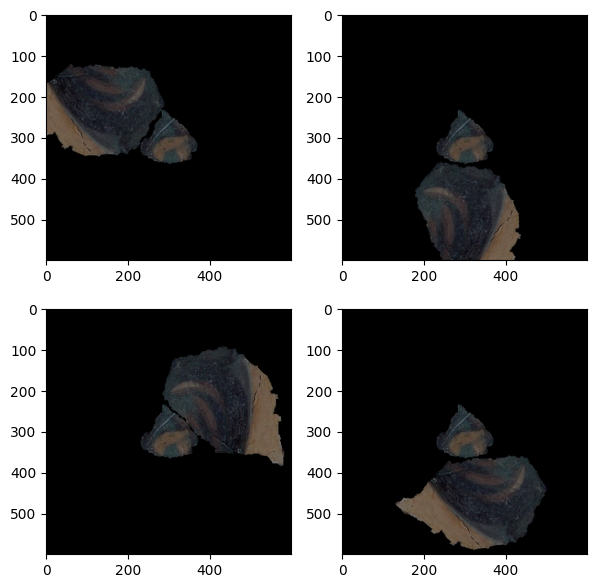

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7,7))
for i in range(len(refined_alignment[(l, r)])):
    tr = refined_alignment[(l, r)][i]
    transformed = shift_fragment(rotate_fragment(pad_fragment_to_size(frags[l], 200), tr.angle), tr.x, tr.y)
    blended = blend_fragments(frags[r], transformed)
    axes[i // 2][i % 2].imshow(blended.fragment)
    print(f"Confidence = {tr.confidence}, translation = {tr}")


0.9156433420783894
Translation(x=212, y=-64, angle=-176.72684591676676, confidence=0.9156433420783894)


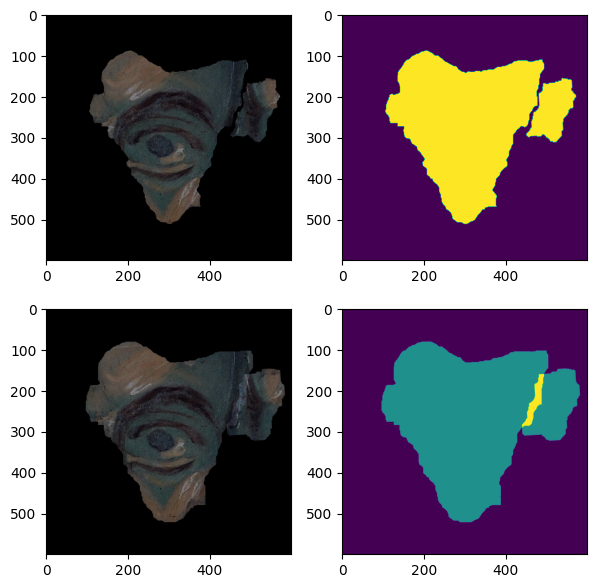

In [20]:
tr = refined_alignment[(l, r)][0]
# tr = Translation(-111, 260, 0, 0) # transform l -> r причем х и у меняются местами
print(tr.confidence)
print(tr)
# padded_frag2 = pad_fragment_to_size(frags[r], 200)
x, y = tr.x, tr.y
transformed = shift_fragment(rotate_fragment(pad_fragment_to_size(frags[l], 200), tr.angle), x, y)
blended = blend_fragments(frags[r], transformed)
visualize_fragment(blended)

# Saving probabilities

In [26]:
import os
import json

In [31]:
def save_probs(refined_alignment, frag_numbers, output_dir: str = '.') -> None:
    """
    Saves probs into json file in output_dir
    
    refined_alignment: dict (l, r) -> list of Translations, where l and r are fragment indices from frag_numbers
    frag_numbers: list of fragment ids
    output_dir: str
    """
    dict_for_json = {}
    for l, r in refined_alignment:
        dict_for_json[f"{frag_numbers[l]}_{frag_numbers[r]}"] = []
        for tr in refined_alignment[(l, r)]:
            dict_for_json[f"{frag_numbers[l]}_{frag_numbers[r]}"].append({
                'x': tr.x,
                'y': tr.y,
                'angle': tr.angle,
                'confidence': tr.confidence
            })
    with open(os.path.join(output_dir, 'probs.json'), 'w') as f:
        json.dump(dict_for_json, f)
    

In [32]:
save_probs(refined_alignment, frag_numbers, output_dir='.')

# Reestimating

## Merging two fragments 

In [38]:
from extend import extend_image, load_model

Detectron v2 is not installed


In [39]:
%matplotlib inline

In [40]:
def leave_biggest_component (mask):
    """
    mask: np.array, binary mask
    return: np.array, binary mask of the biggest connected component of the mask
    """
    mask = mask.astype('uint8')
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=4)
    sizes = stats[:, -1]

    max_label = 1
    max_size = sizes[1]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]

    img2 = np.zeros(output.shape)
    img2[output == max_label] = 255
    return img2

In [41]:
def compute_gap_mask(anchor, transformed, structure_elem = np.ones((25,25))):
    """
    Computes mask of the gap between the anchor and the transformed fragment
    
    anchor: Fragment
    transformed: Fragment

    return: mask of the gap, np.array[bool]
    """
    two_mask = np.logical_or(anchor.mask, transformed.mask)[:,:,None]
    wide_intersection = np.logical_and(anchor.extended_mask, transformed.extended_mask)[:,:,None]
    merged = cv2.morphologyEx(two_mask * 1.0, cv2.MORPH_CLOSE, structure_elem, iterations=1)
    gap = np.logical_and(
        merged[:,:,None],
        np.logical_not(two_mask)
    )
    gap = leave_biggest_component(gap)
    return gap
    

In [59]:
l, r = 0, 1
align_i = 1

In [60]:
tr = refined_alignment[(l, r)][align_i]
transformed = shift_fragment(rotate_fragment(pad_fragment_to_size(frags[l], 200), tr.angle), tr.x, tr.y)
gap = compute_gap_mask(frags[r], transformed)
blended = blend_fragments(frags[r], transformed)

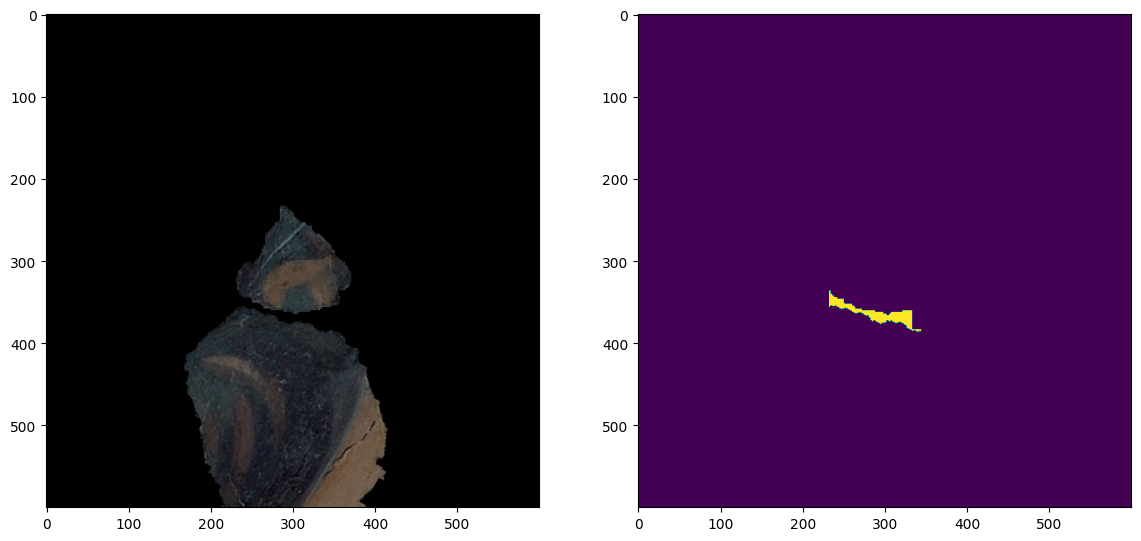

In [61]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
axes[0].imshow(blended.fragment)
axes[1].imshow(gap)

In [62]:
model = load_model()

In [63]:
def inpaint_gap(two_frags, gap_mask, model):
    """
    two_frags: np.array, image with two fragments
    gap_mask: np.array, binary mask of the gap
    model: inpainting model

    return: np.array, inpainted image
    """
    gap_mask = cv2.dilate(gap_mask * 1.0, np.ones((5,5), np.uint8))
    return extend_image(two_frags, gap_mask[:,:,None].astype(bool), model)

In [64]:
inpainted = inpaint_gap(blended.fragment * 255, gap, model)

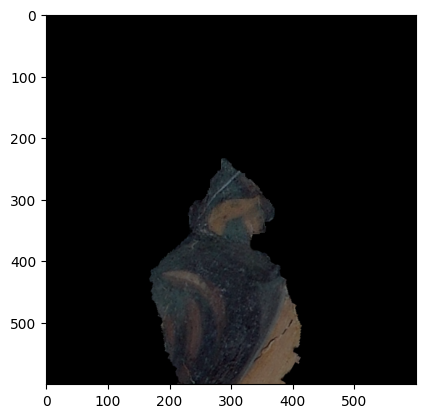

In [65]:
plt.imshow(inpainted)

In [83]:
print(blended.fragment.max())

0.5
